In [1]:
import os 
import time

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pandas.plotting import scatter_matrix

import sklearn
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold # Split data
from sklearn.metrics import accuracy_score # Compute accuracy
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA 

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle
import random
from tqdm import tqdm # Progress Bar

from sklearn.preprocessing import LabelEncoder

# Options
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading Data, Normalizing Data, and PCA

In [2]:
all_preprocessed_data = pd.read_csv("../Data/final_preprocessed_data.csv")

In [3]:
# Split into features and label
labels = all_preprocessed_data['genre_id']
features_numeric = all_preprocessed_data.drop(columns=["track_id", "genre_id"])

In [4]:
# Normalize features
colNames = features_numeric.columns
norm = MinMaxScaler(copy=False)

features_numeric[colNames] = norm.fit_transform(features_numeric[colNames]) 

In [5]:
#PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 200)
pca.fit(features_numeric)
features_numeric_reduced = pca.transform(features_numeric)
features_numeric_reduced.shape

(91901, 200)

### Training Models w/ Hyperparameters Tuned

After performing a grid search on each of the potential models, we identified better hyperparameters than previous experiments.

Decision Tree: Best parameters: {'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt'}, 0.38866220553832764
Random Forest: Fitting 5 folds for each of 11 candidates, totalling 55 fits, Best parameters: {'max_depth': 14}, 0.5328158720371412

KNN: Best parameters n = 3 neighbors

MLP Fitting 5 folds for each of 4 candidates, totalling 20 fits Best parameters: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100, 200, 300), 'mlp__learning_rate': 'adaptive'}, 0.4276115342763873, 0.44493208320487476

In [6]:
def train_models_CV(X, y, metric):

    kf = StratifiedKFold(5, random_state=42, shuffle=True)

    # KNN
    knn_clf = KNeighborsClassifier(n_neighbors=3)
    start_time = time.time()
    scores_knn = cross_val_score(knn_clf, X, y, scoring=metric, cv=kf)  
    print("--- KNN: %s seconds ---" % (time.time() - start_time))
    print("KNN score: " + str(np.mean(scores_knn)))
    print("-----------------------------------\n")
    
    # Random forest
    rf_clf = RandomForestClassifier(max_depth=14, random_state=42)
    start_time = time.time()
    scores_rf = cross_val_score(rf_clf, X, y, scoring=metric, cv=kf)
    print("--- RF: %s seconds ---" % (time.time() - start_time))
    print("RF score: " + str(np.mean(scores_rf)))
    print("-----------------------------------\n")
    
    # MLP
    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 200, 300), activation='relu', learning_rate='adaptive')
    start_time = time.time()
    scores_mlp = cross_val_score(mlp_clf, X, y, scoring=metric, cv=kf)
    print("--- MLP: %s seconds ---" % (time.time() - start_time))
    print("MLP score: " + str(np.mean(scores_mlp)))
    print("-----------------------------------\n")
    
    # Ensemble Classifier (Majority voting) without NB
    ensemble = VotingClassifier(estimators=[
                                          ('knn', knn_clf), 
                                          ('rf', rf_clf),
                                          # ('svmRbf', svmRbf_clf), 
                                          # ('svmPoly', sgd_clf), 
                                          ('mlp', mlp_clf)],
                              voting='soft', 
                              weights=[1,1,1])
    start_time = time.time()
    scores_eclf = cross_val_score(ensemble, X, y, scoring=metric, cv=kf)
    print("--- Ensemble: %s seconds ---" % (time.time() - start_time))
    print("Ensemble score: " + str(np.mean(scores_eclf)))
    print("-----------------------------------\n")

    scores = { 
        'KNN'     : scores_knn, 
        # 'Naive Bayes'      : scores_nb,
        'Random Forest'      : scores_rf,
        # 'SVM (RBF)'     : scores_svm,
        # 'SGD'     : scores_sgd,
        'MLP'     : scores_mlp, 
        'Ensemble (without NB)'    : scores_eclf
        
    }
    
    return scores 

In [7]:
scores = train_models_CV(features_numeric_reduced, labels, 'accuracy')

--- KNN: 16451.738191604614 seconds ---
KNN score: 0.6748893204111095
-----------------------------------

--- RF: 656.7210066318512 seconds ---
RF score: 0.48513077355093986
-----------------------------------

--- MLP: 4299.691114902496 seconds ---
MLP score: 0.6215710343136532
-----------------------------------

--- Ensemble: 8579.277710914612 seconds ---
Ensemble score: 0.6960534293495928
-----------------------------------



# Misc Work

### Training Models w/ Varying Amount of Data Used for Training

In [ ]:
def learning_curve(X, y):
  models = {
        'KNN'     : [], 
        # 'Naive Bayes'      : [],
        'Random Forest'      : [],
        # 'SVM (RBF)'     : [],
        # 'SGD'     : [],
        'MLP'     : [], 
        'Ensemble (without NB)'    : []
  }
  for size in np.arange(0.10, 0.80, 0.10):
    X_train, _, y_train, _ = train_test_split(X, y, test_size=(1-size), random_state=1, stratify=labels)
    print(X_train.shape, y_train.shape)
    scores = train_models_CV(X_train, y_train, 'accuracy')
    for model, mean_scores in models.items():
      score = scores[model]
      models[model].append(np.mean(score))
  return models

In [ ]:
models_X = learning_curve(features_numeric_reduced, labels)

### Checking the Accuracy of the Models vs Proportion of Data used for Training

Text(0.5, 1.0, 'Accuracy VS. Proportion of data used for Training')

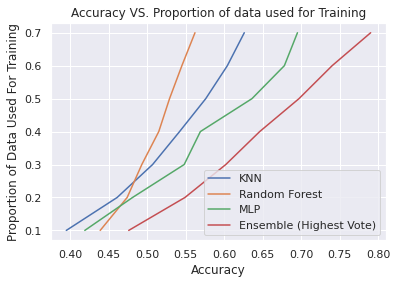

In [ ]:
proportion_data_y = [i for i in np.arange(0.10, 0.80, 0.10)]

## Results of training models... One at a time
models_X = {
    "KNN" : [0.395, .461, 0.507, 0.542, 0.576, 0.604, 0.626],
    "Random Forest" : [0.439, 0.474, 0.493, 0.515, 0.529, 0.545, 0.562],
    "MLP" : [0.419, 0.481, 0.548, 0.569, 0.636, 0.678, 0.695],
    "Ensemble (Highest Vote)" : [0.476, 0.549, 0.602, 0.646, 0.697, 0.74, 0.79],
}

for model, score in models_X.items():
  plt.plot(models_X[model], proportion_data_y, label=model)
  plt.legend()

plt.ylabel("Proportion of Data Used For Training")
plt.xlabel("Accuracy")
plt.title("Accuracy VS. Proportion of data used for Training")

### Work Done To Find Best Hypeparameters

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_numeric_reduced, labels, test_size=0.60, random_state=1, stratify=labels)

In [ ]:
tree = DecisionTreeClassifier(random_state=42)

tree_params = {'max_depth': range(1, 20),
               'max_features': ['sqrt', 'log2'],
               'criterion': ['gini', 'entropy']
               }

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)


print(f"Best parameters: {tree_grid.best_params_}") 

tree_grid.best_score_

accuracy_score(y_test, tree_grid.predict(X_test)) 

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best parameters: {'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt'}


0.38866220553832764

In [ ]:
print('Results on the test set:')
print(classification_report(y_test, tree_grid.predict(X_test)))

Results on the test set:
              precision    recall  f1-score   support

         1.0       0.42      0.45      0.43      3045
        10.0       0.30      0.31      0.30      2728
        12.0       0.26      0.24      0.25      1481
        17.0       0.47      0.51      0.49      2506
        21.0       0.43      0.38      0.40      1269
        25.0       0.48      0.50      0.49      1797
        32.0       0.38      0.35      0.36      2685
        38.0       0.37      0.35      0.36      2870

    accuracy                           0.39     18381
   macro avg       0.39      0.38      0.39     18381
weighted avg       0.39      0.39      0.39     18381



In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(3, 30, 2)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

print(f"Best parameters: {knn_grid.best_params_}") 
print("Score: " + str(knn_grid.best_score_))

accuracy_score(y_test, knn_grid.predict(X_test)) 

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best parameters: {'knn__n_neighbors': 1}
Score: 0.5612622415669206


0.6003336899947408

In [ ]:
print('Results on the test set:')
print(classification_report(y_test, knn_grid.predict(X_test)))

Results on the test set:
              precision    recall  f1-score   support

         1.0       0.62      0.58      0.60      9135
        10.0       0.55      0.53      0.54      8184
        12.0       0.54      0.61      0.57      4442
        17.0       0.65      0.74      0.70      7517
        21.0       0.58      0.69      0.63      3806
        25.0       0.65      0.80      0.72      5392
        32.0       0.62      0.46      0.53      8054
        38.0       0.56      0.52      0.54      8611

    accuracy                           0.60     55141
   macro avg       0.60      0.62      0.60     55141
weighted avg       0.60      0.60      0.60     55141



In [ ]:
knn_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 30)},
             verbose=True)

In [ ]:
pd.DataFrame(knn_grid.cv_results_)

# 3 neighbors 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.52,0.10,25.72,1.89,1,{'knn__n_neighbors': 1},0.57,0.56,0.57,0.55,0.55,0.56,7.73e-03,1
1,0.67,0.06,25.01,1.15,2,{'knn__n_neighbors': 2},0.48,0.47,0.49,0.46,0.47,0.48,7.50e-03,5
2,0.53,0.10,25.12,0.80,3,{'knn__n_neighbors': 3},0.49,0.49,0.49,0.47,0.48,0.48,5.56e-03,2
3,0.40,0.01,26.85,0.58,4,{'knn__n_neighbors': 4},0.48,0.48,0.49,0.48,0.47,0.48,6.64e-03,3
4,0.43,0.06,26.76,0.30,5,{'knn__n_neighbors': 5},0.47,0.48,0.48,0.47,0.47,0.48,6.28e-03,4
5,0.56,0.15,26.59,0.87,6,{'knn__n_neighbors': 6},0.47,0.47,0.47,0.46,0.47,0.47,3.93e-03,6
6,0.58,0.17,24.46,1.88,7,{'knn__n_neighbors': 7},0.46,0.47,0.47,0.46,0.46,0.46,4.84e-03,7
7,0.48,0.08,24.75,1.72,8,{'knn__n_neighbors': 8},0.46,0.47,0.46,0.46,0.46,0.46,4.22e-03,8
8,0.72,0.12,23.14,0.46,9,{'knn__n_neighbors': 9},0.46,0.47,0.47,0.46,0.45,0.46,5.71e-03,9
9,0.55,0.11,23.11,1.08,10,{'knn__n_neighbors': 10},0.45,0.46,0.46,0.46,0.45,0.46,4.55e-03,10


In [ ]:
tree_rf = RandomForestClassifier(random_state=42)
tree_rf_params = {'max_depth': range(4, 15),
              #  'n_estimators': range(100, 2000, 100),
              #  'criterion': ['gini', 'entropy']
               }

tree_rf_grid = GridSearchCV(tree_rf, tree_rf_params, cv=5, n_jobs=-1, verbose=True)

tree_rf_grid.fit(X_train, y_train)


print(f"Best parameters: {tree_rf_grid.best_params_}") 

tree_rf_grid.best_score_

accuracy_score(y_test, tree_rf_grid.predict(X_test)) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best parameters: {'max_depth': 14}


0.5328158720371412

In [ ]:
print('Results on the test set:')
print(classification_report(y_test, tree_rf_grid.predict(X_test)))

Results on the test set:
              precision    recall  f1-score   support

         1.0       0.57      0.64      0.60      9135
        10.0       0.43      0.43      0.43      8184
        12.0       0.67      0.09      0.16      4442
        17.0       0.57      0.71      0.63      7517
        21.0       0.62      0.58      0.60      3806
        25.0       0.52      0.76      0.61      5392
        32.0       0.54      0.50      0.52      8054
        38.0       0.51      0.47      0.48      8611

    accuracy                           0.53     55141
   macro avg       0.55      0.52      0.51     55141
weighted avg       0.54      0.53      0.52     55141



In [ ]:
# SGD
sgd_clf = SGDClassifier(loss='log')

sgd_clf_params = {'max_iter': range(500, 3000, 100)}

sgd_clf_grid = GridSearchCV(sgd_clf, sgd_clf_params, cv=5, n_jobs=-1, verbose=True)

sgd_clf_grid.fit(X_train, y_train)


print(f"Best parameters: {sgd_clf_grid.best_params_}") 

sgd_clf_grid.best_score_

accuracy_score(y_test, sgd_clf_grid.predict(X_test)) 

In [ ]:
print('Results on the test set:')
print(classification_report(y_test, sgd_clf_grid.predict(X_test)))

In [ ]:
# SVM
svm_clf = SVC(probability=True)

svm_params = {'kernel': ["linear", "poly", "rbf", "sigmoid", "precomputed"]}

svm_grid = GridSearchCV(svm_clf, svm_params, cv=5, n_jobs=-1, verbose=True)

svm_grid.fit(X_train, y_train)


print(f"Best parameters: {svm_grid.best_params_}") 

svm_grid.best_score_

accuracy_score(y_test, svm_grid.predict(X_test)) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
print('Results on the test set:')
print(classification_report(y_test, svm_grid.predict(X_test)))

In [ ]:
# MLP
mlp_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier())])

mlp_params = {'mlp__hidden_layer_sizes': [(200, 50), (100,100), 
                                          (100, 200, 100, 200), 
                                          (100, 200, 300)],
              'mlp__activation': ['relu'],
              # 'mlp__solver': ['sgd', 'adam', 'lbfgs'],
              # 'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
              'mlp__learning_rate': ['adaptive'],
              }

mlp_grid = GridSearchCV(mlp_pipe, mlp_params, cv=5, n_jobs=-1, verbose=True)

mlp_grid.fit(X_train, y_train)


print(f"Best parameters: {mlp_grid.best_params_}") 

print(mlp_grid.best_score_)

print(accuracy_score(y_test, mlp_grid.predict(X_test)))

print('Results on the test set:')
print(classification_report(y_test, mlp_grid.predict(X_test)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100, 200, 300), 'mlp__learning_rate': 'adaptive'}
0.4276115342763873
0.44493208320487476
Results on the test set:
              precision    recall  f1-score   support

         1.0       0.50      0.48      0.49      9135
        10.0       0.37      0.39      0.38      8184
        12.0       0.31      0.27      0.29      4442
        17.0       0.57      0.56      0.57      7517
        21.0       0.57      0.54      0.55      3806
        25.0       0.53      0.54      0.53      5392
        32.0       0.42      0.41      0.41      8054
        38.0       0.35      0.39      0.37      8611

    accuracy                           0.44     55141
   macro avg       0.45      0.45      0.45     55141
weighted avg       0.45      0.44      0.45     55141



In [ ]:
pd.DataFrame(mlp_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,142.74,11.06,0.19,5.06e-03,relu,"(200, 50)",adaptive,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",0.41,0.42,0.41,0.42,0.41,0.41,3.27e-03,3
1,154.90,32.39,0.15,9.28e-03,relu,"(100, 100)",adaptive,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",0.39,0.40,0.39,0.39,0.39,0.39,4.04e-03,4
2,141.56,21.20,0.22,1.10e-02,relu,"(100, 200, 100, 200)",adaptive,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",0.41,0.42,0.42,0.42,0.42,0.42,3.38e-03,2
3,195.94,17.20,0.21,3.63e-02,relu,"(100, 200, 300)",adaptive,"{'mlp__activation': 'relu', 'mlp__hidden_layer...",0.42,0.44,0.43,0.42,0.43,0.43,7.62e-03,1


In [ ]:
def plot_score_comparison(scores, metric):
    """
    plot_score_comparison plots the score comparison of the K-Fold Cross Validation.
    We can visually compare the performance of each model.
    
    Input :  scores            Dictionary: {model name : list of scores for the model}
             metric            String: metric used
    
    Author: Conrad Pereira
    
    """
    fig = plt.figure(figsize=(10,6))
    fig.suptitle(metric + ' Score Comparison using K-Fold Cross-Validation')
    ax = fig.add_subplot(111)
    for i, (k, v) in enumerate(scores.items()):
        ax.scatter(i * np.ones(len(v)) + 1, v, label=k, alpha=0.5)
    for i in range(5):
        ax.plot(range(1,len(scores)+1), [scores[k][i] for k in scores.keys()], c='k', alpha=0.2)
    ax.boxplot(scores.values())
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

# Selecting Training/Validation/Test Size and Optimal Models


Initially, we trained on a small sample of the data, after increasing the size of the training data and performing a grid search for better hyperparameters we found that accuracy increased significantly. With our best model being an ensemble (highest vote of our best performing models Random Forest, KNN, and MLP) that achieved an accuracy of 70% on the test set. This is a great result, considering that we had initially only reached about 48% accuracy with the ensemble model. As seen in the chart below, it is useful to increase the size of the data, with some models improving more than others when training on a larger amounts of data. In this use case, we want to use as much data as possible when training because we have no time constraints for training/prediction, we only care about getting the best possible result on the test set. In a real world environment, we may choose to use a less powerful model with lower training and prediction time in order to optimize an application and reduce use of computing resources.




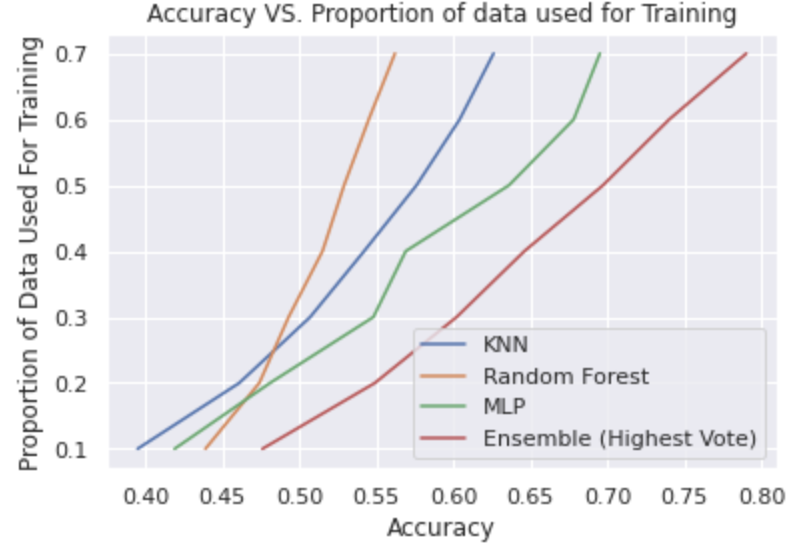
